# Classification of genre - logistic regression and hierarchical model

Importing required libraries:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils
from sklearn.utils import shuffle

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

Loading data:

In [4]:
#### pop = 1 ####
pop1 = pd.read_csv("SpotifyAudioFeatures2017.csv")
pop2 = pd.read_csv("SpotifyAudioFeatures2018.csv")
pop3 = pd.read_csv("SpotifyAudioFeatures2019.csv")
df_pop = pd.concat([pop1, pop2,pop3])
df_pop["genre"] = [1]*len(df_pop)

#### metal = 2 ####
met1 = pd.read_csv("SpotifyAudioFeatures2017metal.csv")
met2 = pd.read_csv("SpotifyAudioFeatures2018metal.csv")
met3 = pd.read_csv("SpotifyAudioFeatures2019metal.csv")
df_met = pd.concat([met1, met2, met3])
#df_met = pd.read_csv("SpotifyAudioFeatures201720182019metal.csv")
df_met["genre"] = [2]*len(df_met)

#### classical = 3 ####
df_clas = pd.read_csv("SpotifyAudioFeaturesclassical.csv")
df_clas["genre"] = [3]*len(df_clas)

#### rap = 4 ####
rap1 = pd.read_csv("SpotifyAudioFeatures2017rap.csv")
rap2 = pd.read_csv("SpotifyAudioFeatures2018rap.csv")
rap3 = pd.read_csv("SpotifyAudioFeatures2019rap.csv")
df_rap = pd.concat([rap1, rap2, rap3])
#df_rap = pd.read_csv("SpotifyAudioFeatures201720182019rap.csv")
df_rap["genre"] = [4]*len(df_rap)

df = pd.concat([df_rap,df_met,df_clas,df_pop])
#df.to_csv("genredata.csv")

In [5]:
print("Shape of pop (1): ", df_pop.shape)
print("Shape of metal (2): ", df_met.shape)
print("Shape of classical (3): ", df_clas.shape) 
print("Shape of rap (4): ",df_rap.shape)

Shape of pop (1):  (6018, 19)
Shape of metal (2):  (6010, 19)
Shape of classical (3):  (5040, 19)
Shape of rap (4):  (5928, 19)


In [6]:
# load csv
df_tracks = pd.read_csv("genredata.csv")
df_tracks = df
#df_tracks = df_tracks.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)
df_tracks = df_tracks.dropna(axis = 0)
df_tracks.head()

,Unnamed: 0,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
0,0,Metro Boomin,Up To Something (feat. Travis Scott & Young Thug),4RGacGFT2ztXhGgzeaYzIR,66,0.3190,0.799,184360,0.616,0.000000,1,0.1340,-8.809,1,0.1570,114.014,4,0.6670,4
1,1,Bryson Tiller,Run Me Dry,5GG3knKdxKWrNboRijxeKF,70,0.3930,0.646,169267,0.756,0.000032,9,0.2020,-9.017,0,0.4870,193.881,4,0.5960,4
2,2,Denzel Curry,SUPER SAIYAN SUPERMAN | ZUPER ZA1YAN ZUPERMAN,3HXSQWIyz7CUEI96kUurwn,63,0.0543,0.760,132813,0.715,0.000009,1,0.1190,-7.128,1,0.0428,142.035,4,0.0479,4
3,3,Joey Bada$$,TEMPTATION,7L9g4cPfohScjJ8mGwLQWr,70,0.3970,0.775,244198,0.707,0.000000,10,0.8740,-5.339,0,0.1520,104.979,4,0.7800,4
4,4,Offset,Legacy (feat. Travis Scott & 21 Savage),7pMRoGLEJuFM2wl5pt0R99,85,0.1780,0.844,244941,0.513,0.000000,1,0.0845,-8.769,1,0.3350,128.085,4,0.3440,4


Preprocessing data:

In [48]:
#df_tracks = shuffle(df_tracks)
grouped = df_tracks.groupby(['artist_name','track_name'], as_index=True).size()
grouped[grouped > 1].count()
df_tracks.drop_duplicates(subset=['artist_name','track_name'], inplace=True)

# doing the same grouping as before to verify the solution
grouped_after_dropping = df_tracks.groupby(['artist_name','track_name'], as_index=True).size()
grouped_after_dropping[grouped_after_dropping > 1].count()

df_tracks[df_tracks.duplicated(subset=['artist_name','track_name'],keep=False)].count()
df = df_tracks
#df = shuffle(df)
df.shape
#ind = df["Unnamed: 0"]
#df.to_csv("genredata.csv")

(13200, 19)

# Working with dataset "genredata.csv"

In [203]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils
from sklearn.utils import shuffle

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [204]:
df = pd.read_csv("genredata.csv")
len(df[df["genre"]==1])

6018

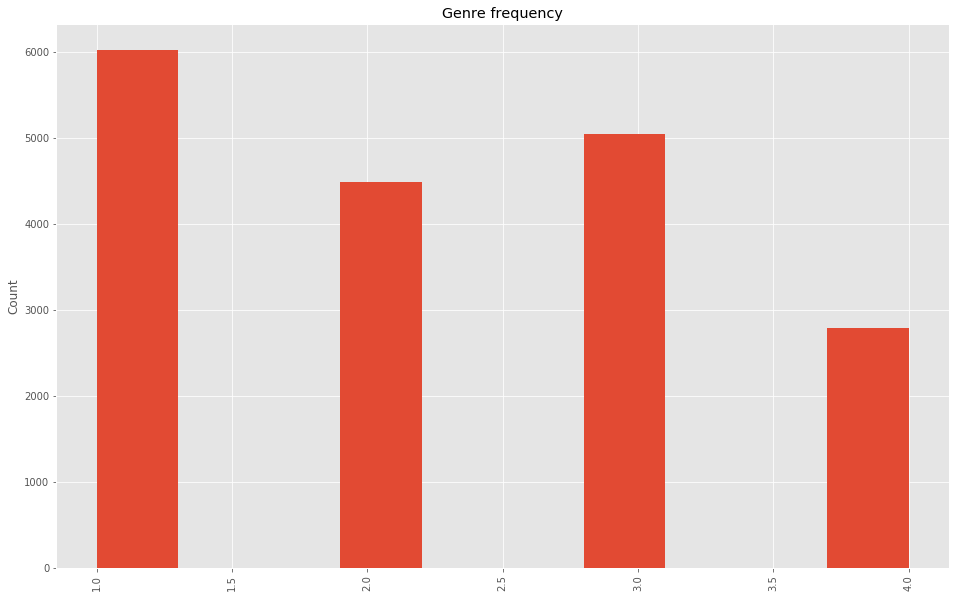

In [205]:
plt.hist(df['genre'])
plt.ylabel('Count')
plt.title('Genre frequency')
plt.xticks(rotation=90)
plt.show()

In [206]:
import seaborn as sb

# Subset to make model less time-consuming

In [207]:
df = shuffle(df)
df = df[:200]

In [208]:
# separate between features/inputs (X) and target/output variables (y)
mat = df.drop(['artist_name','track_name','track_id','Unnamed: 0.1'],axis = 1)
mat = mat.values



In [209]:
#re-enumrate track ids
i = 0
for i in range(len(mat)):
    mat[i,0] = i+1
mat[:,0]

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

In [219]:
X = mat[:,1:-1].astype("float")
print(X.shape)
y = mat[:,-1].astype("int")
print(y.shape)
#ind = mat[:,0].astype("int")
ind = mat[:,0].astype("int")

(200, 14)
(200,)


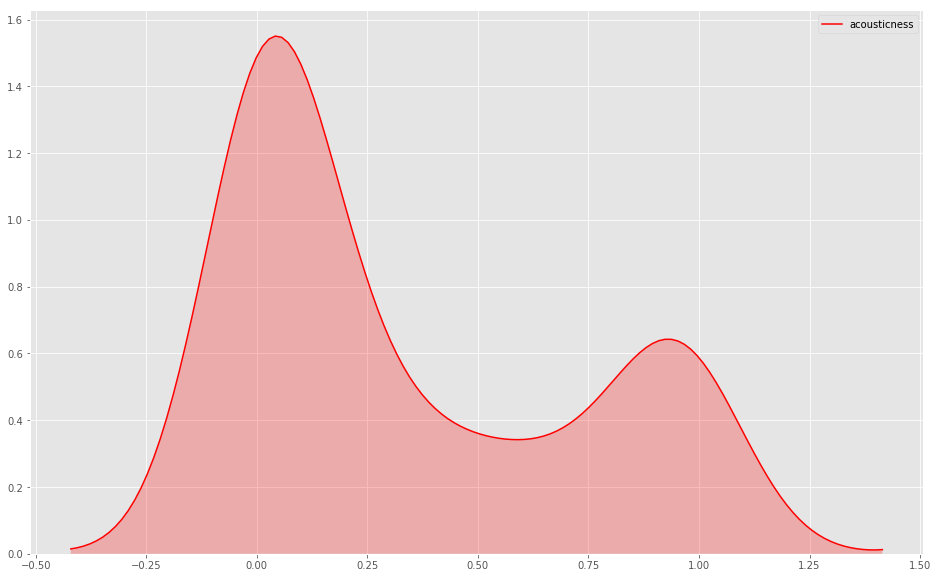

In [220]:
ax = sb.kdeplot(df["acousticness"], shade=True, color="r") #Show distribution of genres (classes)

In [221]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

Train/test split:

In [222]:
train_perc = 0.8 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
ind_train = ind[ix_train]
ind_test = ind[ix_test]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 160
num test: 40


Our baseline logistic regression model from sklearn:

In [223]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='ovr')
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("Predictions:", y_hat)
print("True values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

Predictions: [2 2 3 1 2 1 2 1 3 2 3 1 2 3 2 1 1 1 3 1 3 1 3 3 2 1 3 1 1 3 2 1 1 2 1 1 1
 3 1 3]
True values: [2 2 3 1 3 1 2 4 3 3 3 1 2 3 2 1 1 1 3 1 3 1 3 3 2 4 3 1 1 3 2 1 1 1 1 1 1
 3 4 3]
Accuracy: 0.85


## Hierarchical logistic regression in STAN

Our dataset consists of multiple observations from various tracks. However, when we build our original logistic regression in STAN, our specification assumes that all tracks share a unique set of bias (alpha) coefficients (beta). In other words, this is equivalent to assuming, for example, that all tracks are equally biased towards a given genre (e.g. pop). This is obviously a very strong assumption. We should allow different tracks to have different biases (alpha).

This can be done by placing a hierarchical prior on the intercepts (alpha). The generative process then becomes:

1. For each class $c \in \{1,\dots,C\}$
    2. Draw global mean parameters $\mu_c \sim \mathcal{N}(0,10)$
    3. Draw global variance parameters $\sigma_c \sim \mbox{Cauchy}(0,10)$
    5. For each track $i \in \{1,\dots,I\}$
        4. Draw $\beta_{i,c}$ such that $\beta_{i,c} \sim \mathcal{N}(\mu_c,\sigma_c)$
    6. For each track $i \in \{1,\dots,I\}$
        5. Draw $\alpha_{i,c}$ such that $\alpha_{i,c} \sim \mathcal{N}(\mu_c,\sigma_c)$

6. For each data point $n=\{1,\dots,N\}$
    7. Draw target class $y_n \sim \mbox{Multinomial}(\mbox{Softmax}(\textbf{x}_n,\boldsymbol\alpha_{i_n},\boldsymbol\beta_1,\dots,\boldsymbol\beta_C))$
    
where $i_n$ is the track identifier for track $n$, and $\boldsymbol\mu=\{\mu_1\dots\mu_C\}$ and $\boldsymbol\sigma=\{\sigma_1\dots\sigma_C\}$.

In [231]:
# define Stan model
model_definition = """
data {
    int<lower = 1> N;
    int<lower = 1> D;
    int<lower = 1> C;
    int<lower = 1> I;
    int ind[N];
    matrix[N,D] X;
    int<lower=1,upper=C> y[N];
}

parameters {
    vector<lower=1>[C] mu_prior;
    vector<lower=1>[C] sigma_prior;
    
    matrix[I,C] alpha;
    matrix[C,D] beta;  
    
    
    
}

model {
    for (c in 1:C) {
        mu_prior[c] ~ normal(c,0.5);
        sigma_prior[c] ~ normal(c,0.5);
        
        beta[c,1] ~ normal(0,0.5); //popularity
        beta[c,2] ~ normal(0.5,0.5); //acousticness
        beta[c,3] ~ normal(0.5,0.25); //danceability
        beta[c,4] ~ cauchy(0,0.5); //duration
        beta[c,5] ~ normal(0,0.5); //energy
        beta[c,6] ~ cauchy(0,1); //instrumentalness
        beta[c,7] ~ normal(0,0.5); //key
        beta[c,8] ~ cauchy(0.1,0.2); //liveness
        beta[c,9] ~ cauchy(0,0.5); //loudness
        beta[c,10] ~ normal(0.5,0.5); //mode
        beta[c,11] ~ cauchy(0.1,0.2); //speechiness
        beta[c,12] ~ normal(120,50); //tempo
        beta[c,13] ~ normal(0,0.5); //time_signature
        beta[c,14] ~ cauchy(0.4,0.8); //valence
        
        
        for (i in 1:I){
            alpha[i,c] ~ normal(mu_prior[c],sigma_prior[c]);
        }
    }
    for (n in 1:N){
        y[n] ~ categorical(softmax(alpha[ind[n],:]' + beta * X[n]'));
        
    }    
}
"""

Prepare input data for STAN, compile STAN program and run inference using ADVI (much faster in this case):

In [232]:
# prepare data for Stan model
N, D = X_train.shape
C = int(y_train.max())
I = ind.max()
print("N=%d, D=%d, C=%d, I=%d" % (N,D,C,I))
data = {'N': N, 'D': D, 'C': C, 'I':I, 'ind':ind_train, 'X': X_train, 'y': y_train}

N=160, D=14, C=4, I=200


In [233]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition)
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c7f3a42cecfb931cfe1c3618dfa44a70 NOW.


Wall time: 1min 10s


Lets plot the posterior distributions of some of the parameters of our model (you may have called these variables something else...):

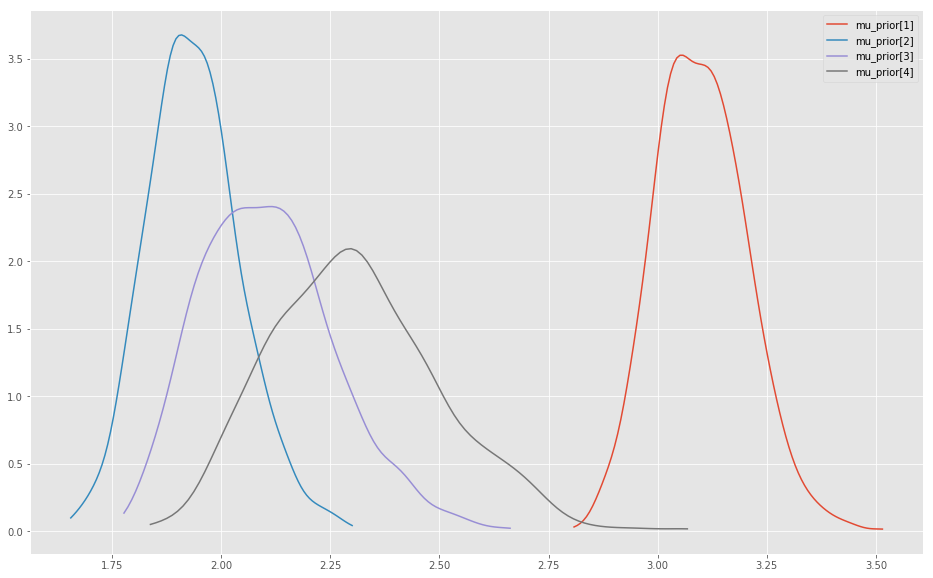

In [234]:
pystan_utils.vb_plot_variables(fit, "mu_prior")

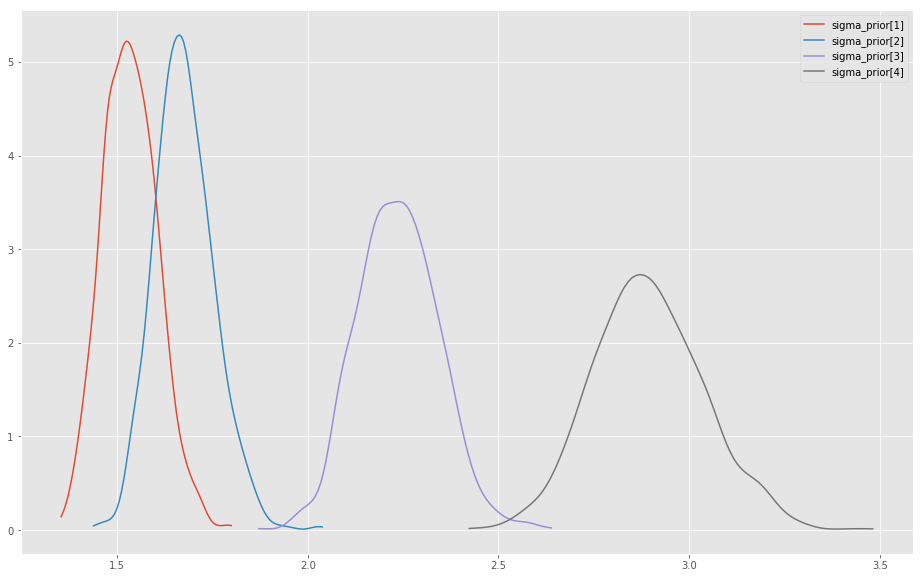

In [235]:
pystan_utils.vb_plot_variables(fit, "sigma_prior")

We can now use the inferred posteriors to make predictions. Lets first use the "pystan_utils" package to extract the expected values of the posterior distribution of the model parameters:

In [236]:
# get fitted parameters
mu_prior = pystan_utils.vb_extract_variable(fit, "mu_prior", var_type="vector")
sigma_prior = pystan_utils.vb_extract_variable(fit, "sigma_prior", var_type="vector")
alpha = pystan_utils.vb_extract_variable(fit, "alpha", var_type="matrix", dims=(C,I))
beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="matrix", dims=(C,D))

Using expected values of the parameters, we can make predictions for the testset. However, we need to account for the fact that we now have different bias parameters per track. 

In [237]:
# make predictions for test set
y_hat = alpha[:,ind_test-1] + np.dot(beta, X_test.T)
y_hat = np.argmax(y_hat, axis=0) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [2 2 3 1 2 1 2 1 3 2 3 1 2 3 2 1 1 1 3 2 3 1 3 3 2 1 3 1 1 3 2 2 1 1 2 3 1
 3 4 3]
true values: [2 2 3 1 3 1 2 4 3 3 3 1 2 3 2 1 1 1 3 1 3 1 3 3 2 4 3 1 1 3 2 1 1 1 1 1 1
 3 4 3]
Accuracy: 0.8


Given the posterior distributions inferred by STAN, we can even analyse the biases of different individuals identified by our model:

In [59]:
for i in range(I):
    print(i, alpha[:,i])

0 [3.56315352 3.18804322 3.36120856 3.39910174]
1 [3.08799422 3.35326616 3.76812638 3.6550334 ]
2 [3.29946013 3.01737194 3.32915793 3.27941196]
3 [3.54182327 3.61703781 3.09397003 3.22907074]
4 [3.52090706 3.35731126 3.06717043 2.6563315 ]
5 [2.80814058 2.91303662 3.13038754 3.35039533]
6 [4.02313082 3.49845148 3.35000958 2.96740642]
7 [3.35666628 3.04420397 3.26105507 3.10487331]
8 [3.23205293 3.30776766 2.94832481 3.05210522]
9 [2.69950128 3.17512838 2.56380649 3.50427252]
10 [2.2984106  3.15539674 3.31597411 3.21017221]
11 [3.23740091 3.54194987 3.25353091 2.78662266]
12 [3.4161638  3.39149122 3.20235408 3.36749457]
13 [3.53215742 3.14921568 3.17268392 3.98449487]
14 [3.54528791 3.53507229 3.31572662 3.31524516]
15 [4.15788368 3.37419202 3.50267346 3.13479177]
16 [3.51615018 3.38666749 3.44683033 3.84419908]
17 [3.92183145 3.28966511 3.07302227 3.37211431]
18 [3.2204346  3.21789654 2.93805563 3.24770862]
19 [3.19066464 4.05371605 3.15077593 3.53449381]
20 [3.43660338 2.98236203 3.39

499 [2.91278821 2.74656586 3.87025509 3.40183053]
500 [3.31844488 2.78566251 3.28375035 3.22645232]
501 [3.11154868 3.53694386 2.83604438 3.52317645]
502 [3.08972968 2.8628807  3.44933906 3.29721816]
503 [3.42471431 2.49744489 2.93429115 2.90613099]
504 [3.47714561 3.3369809  2.93593837 2.98564597]
505 [2.45945582 2.99610077 2.80994148 3.68999237]
506 [3.42351203 2.74442769 3.42409885 3.37084656]
507 [3.32643245 3.24324738 2.72642991 2.99666519]
508 [3.42745703 3.19146288 3.36838518 3.59118035]
509 [3.25414854 3.11410774 2.72863217 3.05401408]
510 [3.20404672 3.3200557  3.08241891 3.22730747]
511 [3.19312565 2.98358795 3.25638833 2.94984264]
512 [3.33562196 3.65115582 3.68276214 3.42020503]
513 [3.60895968 3.70775563 3.48752861 2.67010344]
514 [3.11493803 3.03343429 2.82146741 3.15277183]
515 [3.15136995 2.35271929 2.95570439 3.63107341]
516 [3.26194892 2.7375551  3.12879797 3.49082989]
517 [3.45268562 2.94422228 3.25062448 3.35987799]
518 [3.21978547 2.9166731  2.92111662 2.8864669 ]


998 [3.0710298  3.05711205 2.70425678 3.09026802]
999 [3.09551272 3.17828494 3.01393865 3.1477333 ]
1000 [3.17489606 3.06390538 3.05845259 3.1075918 ]
1001 [2.94460879 2.82568016 3.06764527 2.53952091]
1002 [3.00746482 3.05085007 3.14046202 3.12887087]
1003 [3.09052961 3.17200243 2.96296141 3.1061437 ]
1004 [2.95147266 3.06636186 3.13153226 3.07408674]
1005 [3.07502698 3.04342102 3.02790344 3.13513671]
1006 [3.15999876 3.08660567 3.02531711 2.9058969 ]
1007 [2.88482226 3.08130785 3.17796827 2.90808526]
1008 [3.13521944 3.14221475 3.10362757 2.6199337 ]
1009 [2.90369475 3.11048418 3.09627282 3.07832916]
1010 [3.12298682 3.09131423 3.10119728 3.06130778]
1011 [3.10595349 2.84561897 3.07161224 3.17380268]
1012 [2.95698123 3.08593173 2.64767174 3.14453232]
1013 [3.05451643 3.08815701 3.00270742 3.05168522]
1014 [2.96258185 3.13271278 2.99874188 3.15895163]
1015 [3.10998956 2.95072888 2.98012659 2.94354221]
1016 [3.08411042 3.13966758 3.1259978  3.05679731]
1017 [3.07449797 3.12476317 3.108

1498 [0.9834557  1.11282976 0.39059165 0.99105324]
1499 [0.86194381 0.97114108 0.29568051 1.0388323 ]
1500 [1.46773501 0.81631322 0.0311756  1.03176168]
1501 [1.02293804 1.06649257 0.62600805 1.19562766]
1502 [1.05659109 1.19078004 0.3403076  1.52484128]
1503 [1.05760301 1.12594484 1.04253593 1.57545487]
1504 [1.01444072 1.26352855 1.05657808 0.96385739]
1505 [0.58372067 1.40256483 1.0425007  1.02046704]
1506 [1.09637154 1.25994393 1.45886246 1.38243121]
1507 [1.02098803 1.55453615 0.99838071 1.12885653]
1508 [1.38791965 1.12546035 1.18769023 0.58420529]
1509 [1.16694487 1.01086532 0.90810099 0.91870547]
1510 [0.86469123 0.85755915 1.07547496 1.03777878]
1511 [0.48594293 0.84775961 0.87410986 1.12831714]
1512 [1.22142404 1.10007721 0.17353962 1.03020518]
1513 [1.21308497 1.17627984 0.99828179 0.69467151]
1514 [0.99460709 1.00457679 1.20359664 1.03336671]
1515 [1.05935217 0.97018177 0.65691264 1.05032355]
1516 [1.05991958 0.86915095 0.90402827 1.13761543]
1517 [1.01426861 1.16897663 0.8

1998 [1.01248887 1.23798779 1.73343489 1.0642577 ]
1999 [1.11845609 1.87371402 1.04477838 1.0580278 ]
2000 [1.11777295 1.93533297 1.21540017 1.85055485]
2001 [1.06357033 1.08790202 1.08507582 1.08324318]
2002 [0.99063489 0.39197911 1.22453042 1.10794669]
2003 [1.21460736 1.06172055 1.14241396 1.08018288]
2004 [1.4082539  1.20016015 1.25133291 1.41905304]
2005 [1.10873209 1.09962065 1.53616434 1.09416477]
2006 [0.36945919 1.20887626 1.11637501 1.25667008]
2007 [0.2374785  1.13375086 1.01106613 1.05361038]
2008 [1.23274481 1.07740146 1.06603258 1.30524681]
2009 [1.01320964 0.9823754  1.30709064 1.24729691]
2010 [1.15916636 1.29582066 1.03274972 1.02273024]
2011 [1.44424632 0.99325868 1.93268387 1.07908603]
2012 [1.08817601 1.20963271 1.51953165 1.0333717 ]
2013 [1.04161212 1.08149741 1.12214881 1.10814121]
2014 [1.09914293 1.18740953 1.77912761 1.10691033]
2015 [1.0479567  1.10950891 1.13522187 1.17313803]
2016 [1.02317781 1.08953489 1.27997757 1.09528016]
2017 [1.12178204 1.12389193 1.1

2497 [1.03299252 1.13002342 1.04842198 1.05264997]
2498 [1.12609331 1.04496645 1.10969161 1.11890566]
2499 [1.05997799 1.03061007 1.01959021 1.06566345]
2500 [1.02393672 1.03703147 0.99530196 1.07186633]
2501 [1.03691024 1.06816638 0.96324127 1.05036076]
2502 [0.35295602 1.10938882 1.09882595 1.03385493]
2503 [1.02707045 1.06087766 1.04725307 1.02111132]
2504 [1.07051914 1.06900159 1.02763289 1.01157042]
2505 [1.0623621  1.02309181 1.01179029 1.11182757]
2506 [1.04288544 1.06036187 1.12066521 1.02996806]
2507 [1.09378712 1.06677928 1.08355881 1.06761877]
2508 [1.13144093 1.03909395 1.0558862  1.09611739]
2509 [1.06917184 1.05270366 1.07385158 1.03102622]
2510 [1.04905959 1.09215125 0.13324834 1.09097782]
2511 [1.09670826 0.98471558 1.00784203 1.06672326]
2512 [1.04224648 1.05906491 1.08105479 1.09786078]
2513 [1.10339229 1.05566793 1.09552895 1.05895131]
2514 [1.06495734 1.05199739 1.03376165 1.07023202]
2515 [1.05540072 1.08799244 0.97038054 0.96164349]
2516 [1.06432444 0.23039546 1.0

2997 [1.41072902 1.7550683  1.57665523 1.48063409]
2998 [1.49955364 1.45831368 0.2761424  1.26815547]
2999 [1.52194653 1.55388878 1.30186866 1.47961342]
3000 [1.16111247 1.31945924 1.47780468 1.56301777]
3001 [1.57498624 1.32158945 1.38664338 1.78903031]
3002 [1.60676286 1.52185519 1.52625257 1.53463845]
3003 [1.44408106 1.50330334 1.28702255 1.56208303]
3004 [1.60252688 1.49012639 1.67579665 1.51900653]
3005 [1.482997   1.46192817 1.44433485 2.66698297]
3006 [1.08113823 1.3066187  1.55146925 0.68127328]
3007 [1.51629688 1.25983246 1.56008048 1.50693756]
3008 [1.3500459  1.45007886 1.04004045 2.45285038]
3009 [1.39508415 1.83868692 1.56789953 1.49303109]
3010 [1.51126751 1.49006452 1.37226518 1.56101192]
3011 [1.67449769 1.55105842 1.25356609 1.38969828]
3012 [1.54173616 1.49901521 0.69064302 1.49405748]
3013 [1.51938434 1.52650576 1.55322261 1.37685712]
3014 [0.62115326 1.52994387 1.77209157 1.53680866]
3015 [1.45019701 1.00634163 1.44308751 0.956801  ]
3016 [1.43623641 1.19449788 1.5

3497 [1.51449725 1.53178612 1.50744024 1.44646959]
3498 [1.50143987 1.51503198 1.55712054 1.52890176]
3499 [1.14219457 1.58397081 1.53222135 1.52033633]
3500 [1.3448394  1.53575762 1.59617804 1.49188283]
3501 [1.62408538 1.48500309 1.38356092 1.55394847]
3502 [1.49550203 1.55420171 2.61716834 1.47368562]
3503 [1.66527118 1.59023365 1.64342489 1.52945883]
3504 [1.57085754 1.7949266  1.45536516 1.53717042]
3505 [1.52028333 1.56689199 1.62860825 3.00253682]
3506 [1.56008728 1.57394344 1.60298349 1.55983697]
3507 [0.63023875 1.49976102 1.55440193 1.71622791]
3508 [1.55074033 1.52066361 2.25150314 1.45641044]
3509 [1.52575643 1.48353304 1.53374599 2.01811868]
3510 [1.4392018  1.51743116 1.59501818 1.08931121]
3511 [1.50498244 1.48645716 1.87921151 1.54050595]
3512 [1.61004791 2.81043847 2.39147969 1.42709593]
3513 [1.53876709 1.46970381 1.57338425 1.55982529]
3514 [1.41215354 1.5581271  1.51573444 1.5050891 ]
3515 [1.83150718 1.48924193 1.61709398 2.05735795]
3516 [1.5145822  1.50934788 1.4

3997 [1.52534147 0.73660668 0.8883354  1.23400666]
3998 [1.41240244 1.14678542 1.03238084 1.28792379]
3999 [1.17376197 1.78087461 1.18473511 1.63789856]
4000 [1.06306529 1.63411287 0.65650552 1.32539249]
4001 [1.78304923 1.70118152 1.20010288 0.43228381]
4002 [1.1642186  1.24736929 0.95699566 1.10372147]
4003 [1.12326531 1.20885022 0.58527009 1.39617616]
4004 [1.07646695 0.5848222  1.1556063  1.08178936]
4005 [1.27255453 1.30686438 1.26976344 0.96268098]
4006 [1.1173571  1.10777118 1.1789084  1.52942187]
4007 [1.058104   1.46851716 0.94599951 1.44821037]
4008 [1.41781493 0.66785401 1.12733298 1.24646133]
4009 [0.8763202  1.24933371 1.29658939 1.17206051]
4010 [0.81396422 1.21602461 0.73830124 1.18641112]
4011 [0.95655344 1.37965561 0.59832087 1.27826234]
4012 [1.07634436 1.09383371 1.37551818 1.12800914]
4013 [1.22166306 0.51651874 1.64616364 0.4307908 ]
4014 [1.46323888 0.92315592 1.61869425 1.41630805]
4015 [1.81061025 0.99515597 1.58215913 0.9016461 ]
4016 [1.4967939  1.41284653 0.7

4496 [1.0919631  0.96277533 1.11745719 0.95587972]
4497 [0.91626131 1.12841246 1.13014567 0.76240837]
4498 [1.06689778 0.99166034 0.89655583 1.24075617]
4499 [1.14384616 1.18637859 1.16581204 1.10349459]
4500 [1.0840275  1.16249088 1.1569133  1.13552589]
4501 [1.16630538 1.16642051 1.05768646 1.11433297]
4502 [1.13139049 1.1566903  1.23459418 1.13993813]
4503 [1.11627918 1.17814714 1.22606065 1.10620457]
4504 [1.12294822 1.07867717 1.1650887  1.15011379]
4505 [1.16797581 1.10759687 1.14168123 1.0721762 ]
4506 [1.12855063 1.10033373 1.16495831 1.14206132]
4507 [1.16480471 1.15327296 1.20861149 1.19433855]
4508 [1.18200821 1.18111764 1.20192955 1.18210379]
4509 [1.14448512 1.16331739 1.18643641 1.079066  ]
4510 [1.0982993  1.14726469 1.01999965 1.09661757]
4511 [1.26879143 1.17927375 1.07720558 1.22127474]
4512 [1.16051243 1.09664096 1.15382763 1.08905926]
4513 [1.07677158 1.14775134 1.10853938 1.15655909]
4514 [1.09155872 1.20427608 1.16776958 1.0921531 ]
4515 [1.21976659 1.08134606 1.1

4996 [1.19344171 1.18850067 1.20891209 1.1078743 ]
4997 [1.2327791  1.16163551 1.23420372 1.16928456]
4998 [1.12043779 1.18316538 1.09895383 1.20914529]
4999 [1.12470251 1.18927856 1.15841075 1.2031221 ]
5000 [1.17081414 1.15995886 1.14003145 1.23193265]
5001 [1.17784405 1.21711543 1.18805792 1.18534891]
5002 [1.21244427 1.22136478 1.17702922 1.15788323]
5003 [1.18909723 1.20111878 1.150466   1.16111777]
5004 [1.16465151 1.19496459 1.18368804 1.10141589]
5005 [1.1330237  1.18749806 1.16115885 1.09292216]
5006 [1.17598472 1.18721463 1.21120374 1.11479607]
5007 [1.18122578 1.19045109 1.17633286 1.11905776]
5008 [1.1208638  1.14188233 1.20995152 1.17238948]
5009 [1.21110085 1.20774317 1.13926167 1.14072951]
5010 [1.13115357 1.15803767 1.13248462 1.18644626]
5011 [1.1815251  1.16130983 1.25337783 1.11655906]
5012 [1.04904572 1.18020669 1.16277183 1.15358   ]
5013 [1.21166755 1.21024433 1.14825185 1.18092925]
5014 [1.16936935 1.17815069 1.19475482 1.17777483]
5015 [1.19326601 1.16399746 1.1

Perhaps a histogram allows for a better global analysis:

In [ ]:
# histogram of biases towards mode 4 (car)
plt.hist(alpha[3,:])
plt.title("Biases towards mode 4")
plt.xlabel("alpha[4]")
plt.show()

We can observe that, for most individuals the biases is around 0. However, we can also see that a few individuals really love their cars!

Reflection exercise: can you think of ways in which you could use this model to try to identify policies (e.g. price changes or making terminals more efficient) that would allow to shift people's travel mode choices away from the car (e.g. towards public transport)?